# Multimodal (Image + Text) Retrieval for Ecommerce

The purpose of this demo is to show how to run multi modal search based on Vector Similarity.

By Multi-Modal, we mean  the ability to encode texts and images in the same vector space.

Dataset available at: https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products

References: https://akgeni.medium.com/understanding-openai-clip-its-applications-452bd214e226

## Dependencies 

This demos is built on OpenAI/CLIP. It is necessary install it from the github repo.

In [ ]:
!pip install pandas cassio torch pillow langchain -q

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [14]:
import cassio
import torch
import clip
from PIL import Image
import pandas as pd 
from IPython.display import Image as ShowImage, display
import numpy as np

In [2]:
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(), override=True)

True

## AstraDB Connection

We will use AstraDB, a DBaaS based on Cassandra with built-in Vector Search, to store and query the embieddings.

To open the connection and create the table that will store the data, we will use **CassIO# library** [www.cassio.org].


In [3]:
token = os.environ['ASTRA_DB_APPLICATION_TOKEN']
database_id = os.environ['ASTRA_DB_ID']
keyspace = os.environ.get('ASTRA_DB_KEYSPACE')

In [4]:
# Open the connection
cassio.init(token=token, database_id=database_id)
#Create the table
v_store = cassio.table.MetadataVectorCassandraTable(table="demo_ecommerce", vector_dimension=512)

## The Model

In this case, we will use the OpenAI/CLIP model

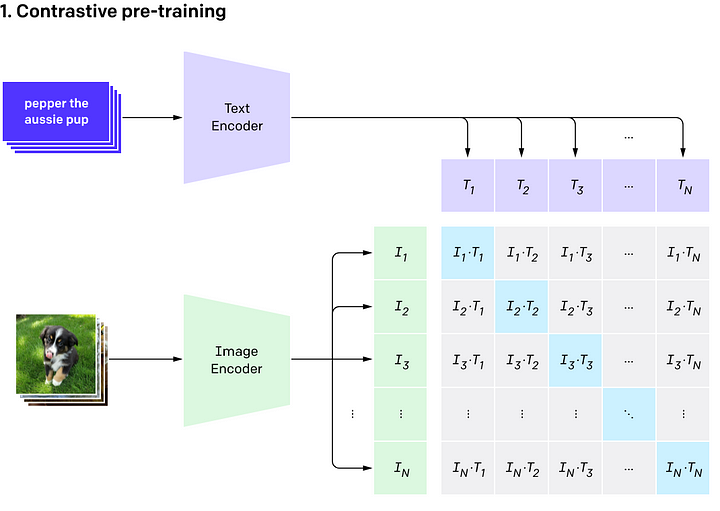

In [10]:
# Checking if GPU is available. Then loading the model.
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)


# Dataset

The dataset used on this demo is available on Kaggle. It contains 20000 products, eith theire names, descriptions, categories and images URL.

We will have to download the images, as the files are not available on Kaggle. This step require time because the download is not fast.

In [21]:
df = pd.read_csv('/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/flipkart_com-ecommerce_sample.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


# Download Images

The original repository doesn't have the images, so it is needed to download them.

In [ ]:
import os
import requests
from tqdm import tqdm
def download_image(url, folder, prefix_file_name):
    # if not os.path.exists(download_folder):
    #     os.mkdir(download_folder)
    file_name = f"{prefix_file_name}_{os.path.basename(url)}"
    file_path = os.path.join(folder, file_name)
    if os.path.exists(file_path):
        return file_path
    else: 
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(response.content)
            return file_path
        else:
            return None

In [25]:
# transforming the string in an array os strings
import ast

def parse_string_to_array(s):
    try:
        return ast.literal_eval(s) if pd.notna(s) else []
    except (SyntaxError, ValueError):
        return []
        
df['image'] = df['image'].apply(parse_string_to_array)
#df['product_category_tree'] = df['product_category_tree'].apply(ast.literal_eval)

/var/folders/cb/kqbz377s0f5cnzwythftzhp40000gp/T/ipykernel_39251/2542729918.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  return ast.literal_eval(s) if pd.notna(s) else []


In [26]:
def extract_category(full_category):
    parse =  parse_string_to_array(full_category)
    if len(parse) > 0:
        return [cat.strip() for cat in parse[0].split(">>")][0]
    else:
        return None
        
df['category'] = df["product_category_tree"].apply(extract_category)

In [ ]:
df.loc[[19999],['image','local_image']]

In [ ]:
%time
# Download imagens
skip = 15000
load = 20000
for index, row in tqdm(df[skip:load].iterrows(), total=df[skip:load].shape[0], desc=f'Reading DF'):
    if (len(row["image"])> 0) and  pd.isna(row["local_image"]):
        df.at[index, "local_image"] = download_image(row["image"][0],"./flipkart/images",f"{row['uniq_id']}")

    # for imgurl in row["image"]:
    #     row["local_image"] = download_image(imgurl,"./flipkart/images",f"{row['uniq_id']}")

# Generating Embeddings

The embeddings will be generated by a "combination" of the image and text embeddings.

In [ ]:
# Based on this paper 
# https://ai.meta.com/research/publications/scaling-autoregressive-multi-modal-models-pretraining-and-instruction-tuning/
def get_clip_embedding(text, image_path):    
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)        
    text = clip.tokenize(text,truncate=True).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    averaged_features = (image_features + text_features) / 2    
    return averaged_features.numpy().tolist()

### Loading to Astra

Generate the embeddings for the combination of text + image.

The text to generate the embedding will consider only the first category and the product name.

In [ ]:
%time
# Loading all flipcart data to the Vector Table
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=f'Reading DF'):
    try:    
        if "local_image" in row.index and row["local_image"] != None: 
            input_img = f'{os.getcwd()}{row["local_image"][1:]}'
            input_text = f"{row['category']} {row['product_name']} "
            v_store.put(row_id=f"row_{index}", body_blob=input_text, 
                        vector=get_clip_embedding(input_text,input_img)[0], 
                        metadata= {"image_url":input_img, "local_image": row["local_image"][1:]})
    except:
        print(f"Error at IX {index}")


print("Finished")

In [6]:
# Function to convert the query in a embedding
def embed_query(q):
    query_embed = clip.tokenize(query,truncate=True).to(device)
    with torch.no_grad():    
        text_features = model.encode_text(query_embed)   
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.numpy().tolist()[0]

In [7]:
# Function to conver the image in a embedding
def embed_image(image_path):
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)    
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.numpy().tolist()[0]

### Validating the similarity between text and image

In [8]:
query = "aluminum anolog watch for men"
text_embedding = embed_query(query)
print(f"Text embedding {text_embedding[:12]}...")

Text embedding [-0.024829497560858727, 0.004579590633511543, -0.028845256194472313, 0.01499729324132204, -0.0035447925329208374, 0.01668880507349968, 0.04074299708008766, -0.005549163557589054, 0.03613070026040077, 0.03830529376864433, 0.016496924683451653, 0.009011134505271912]...


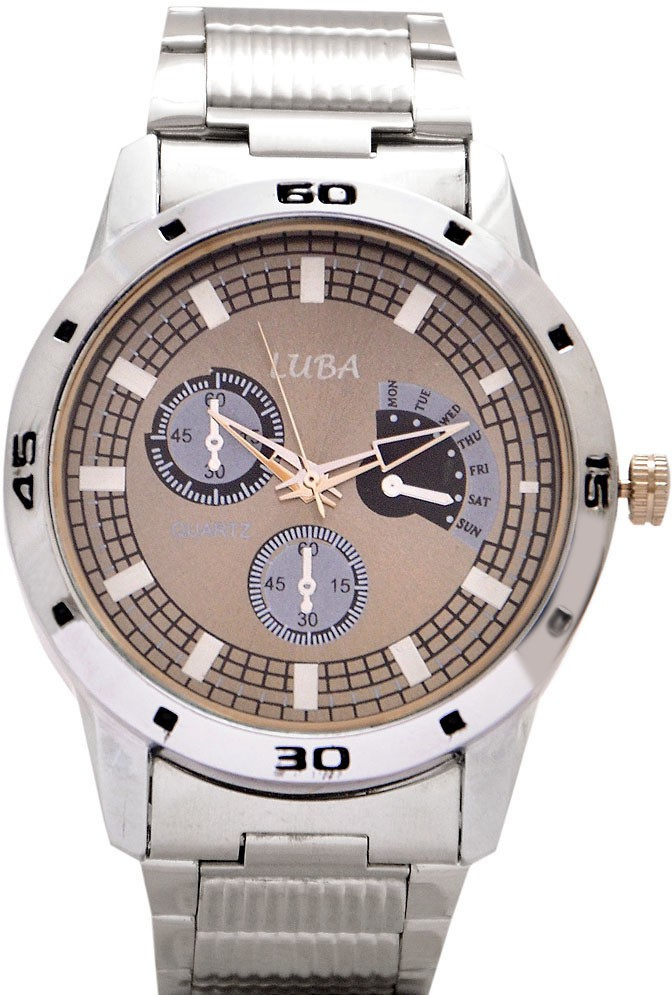

Image embedding [-0.015364978462457657, -0.06570208817720413, 0.04953718185424805, -0.041464176028966904, 0.018786510452628136, 0.007497041020542383, 0.03284502029418945, 0.02251564711332321, 0.04073231294751167, -0.0038496600463986397, 0.068913035094738, 0.012916982173919678]...


In [11]:
file_to_search = '998276640805c5268d5b5f7534ef05e2_bh23-luba-original-imae9mn7hpk7hwrt.jpeg'
image_search = f"/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/{file_to_search}"
display(ShowImage(filename=image_search, width=200) )
image_embedding = embed_image(image_search)
print(f"Image embedding {image_embedding[:12]}...")

In [15]:
# Checking the similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_score = cosine_similarity(np.array([text_embedding]), np.array([image_embedding]))
print(f"Cosine similarity:", cosine_similarity_score[0][0])

Cosine similarity: 0.30896368487212067


# Searching using a description

Search: kids furniture
Results:
----------------------------------------


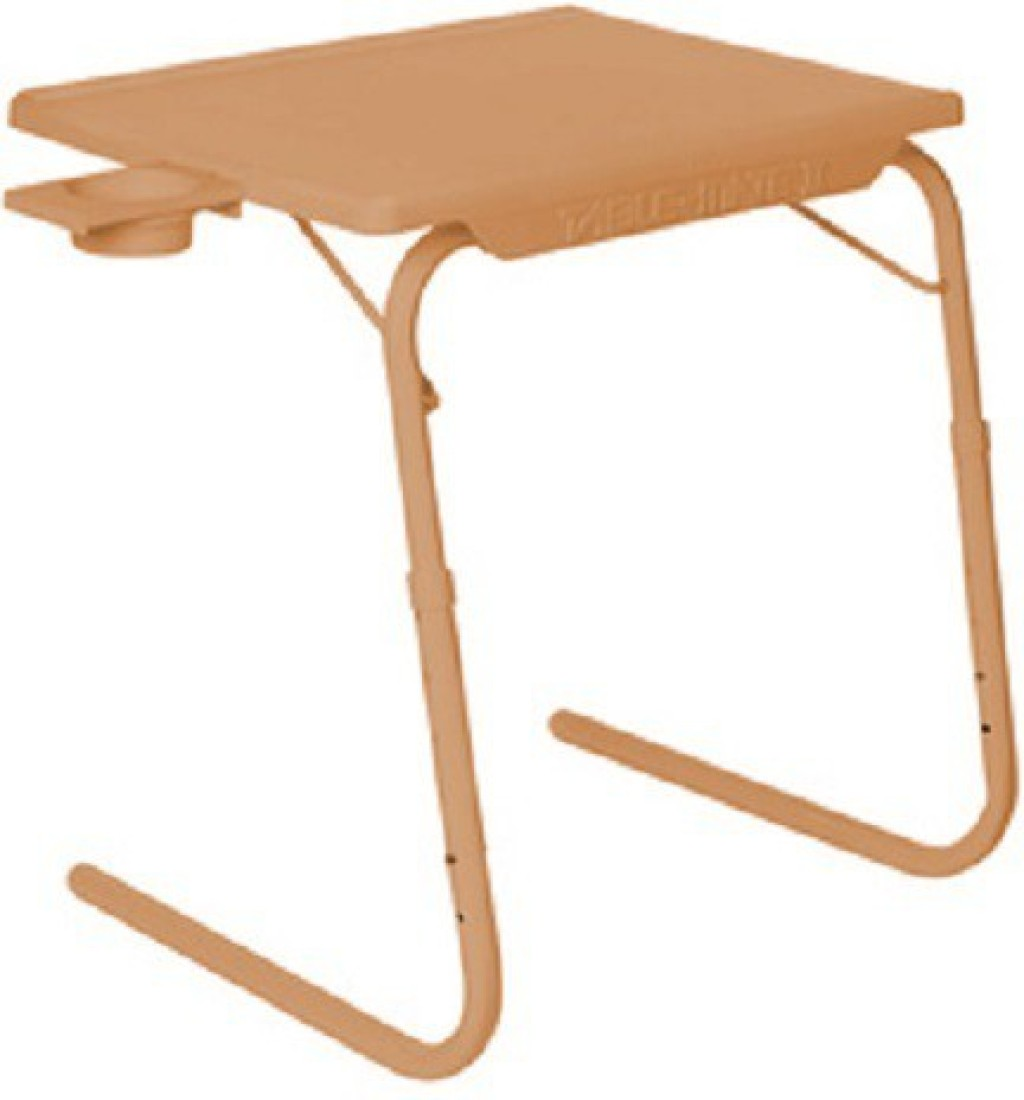

Furniture IBS Plastic Portable Laptop Table 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/50980caa3af3bd7551b10dcc0086a077_avar256-pp-ibs-beige-1100x1100-imae9etdcnvujhcj.jpeg


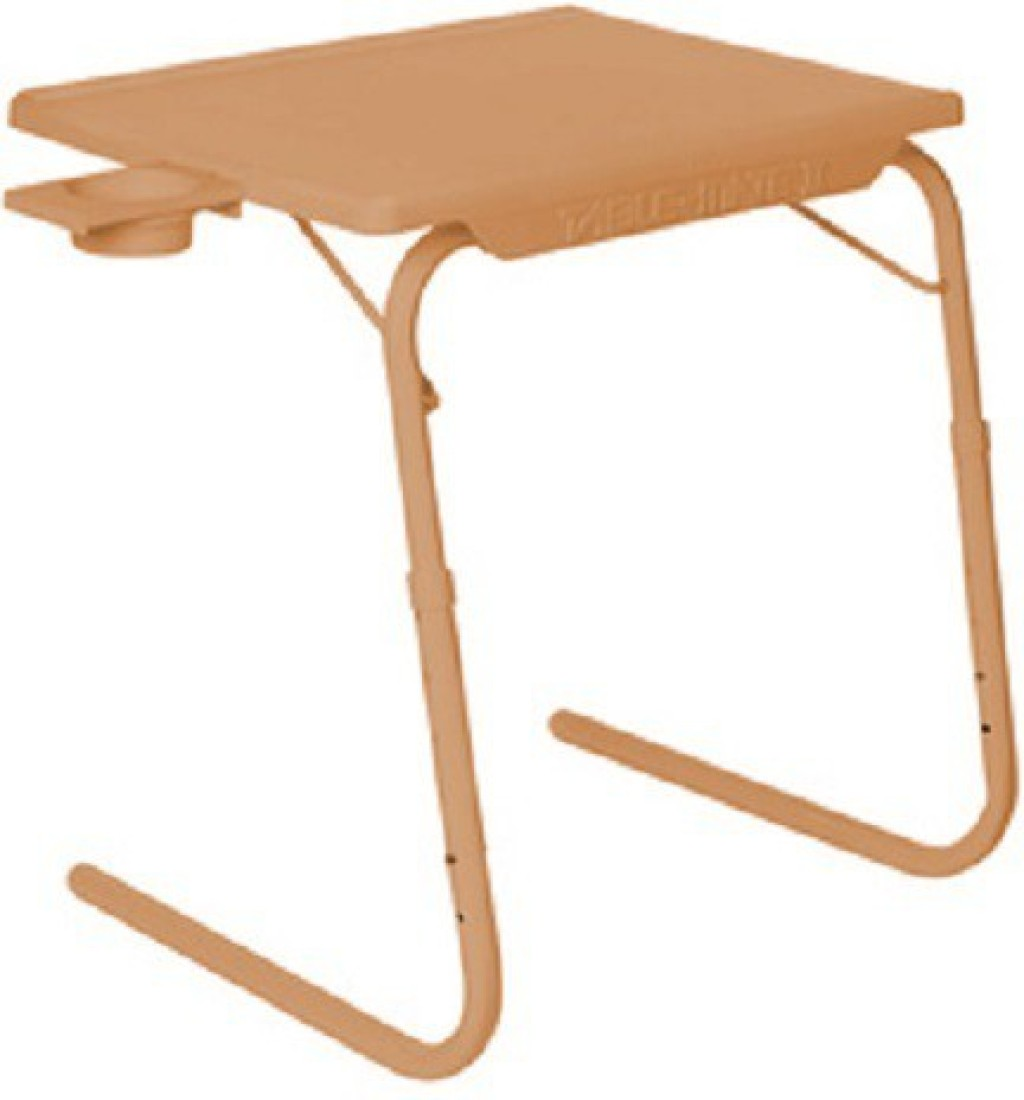

Furniture IBS Plastic Portable Laptop Table 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/e0b45f558a3ff5c0c02c02ee886003e6_avar256-pp-ibs-beige-1100x1100-imae9etdcnvujhcj.jpeg


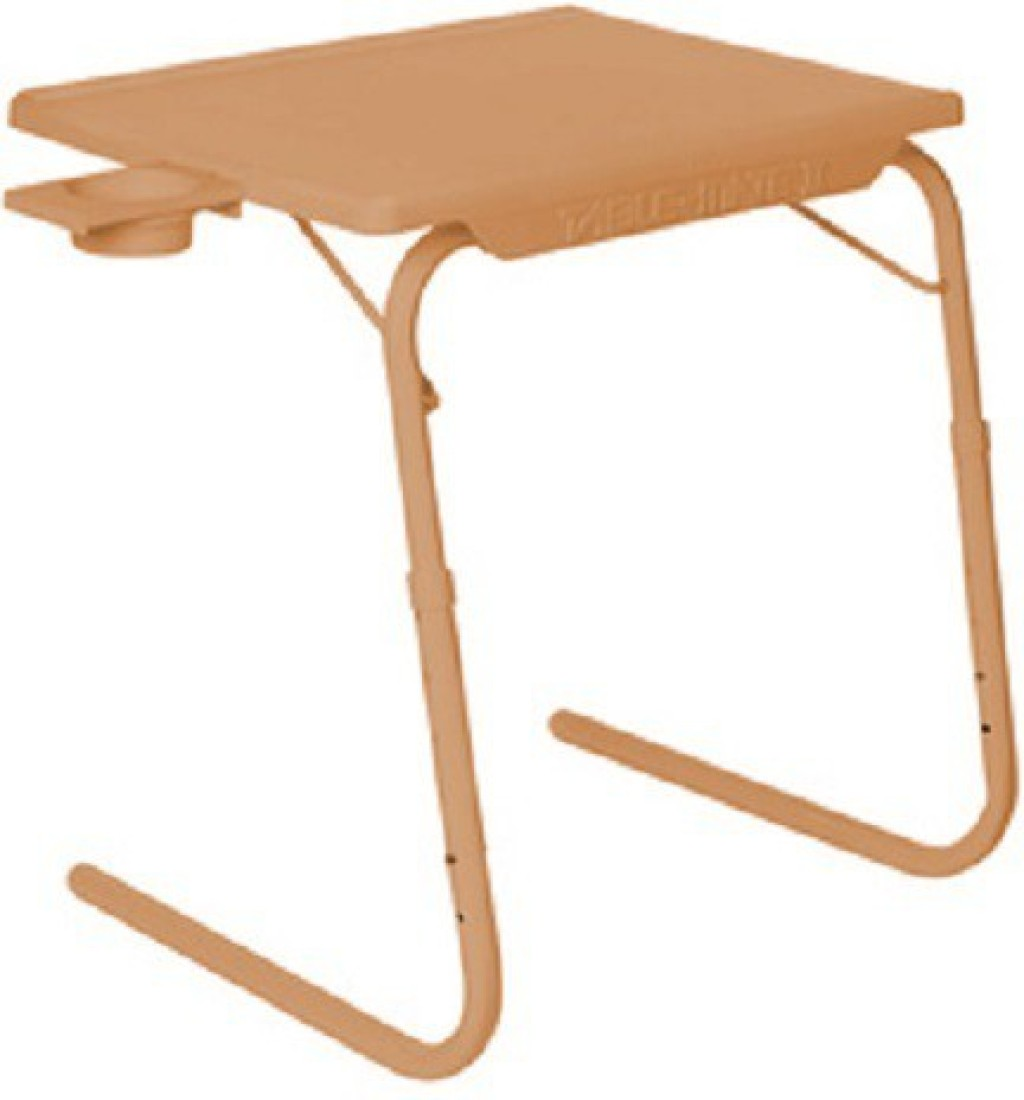

Furniture IBS Plastic Portable Laptop Table 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/181e43c979afff251cad0d4e042ab1c2_avar256-pp-ibs-beige-1100x1100-imae9etdcnvujhcj.jpeg


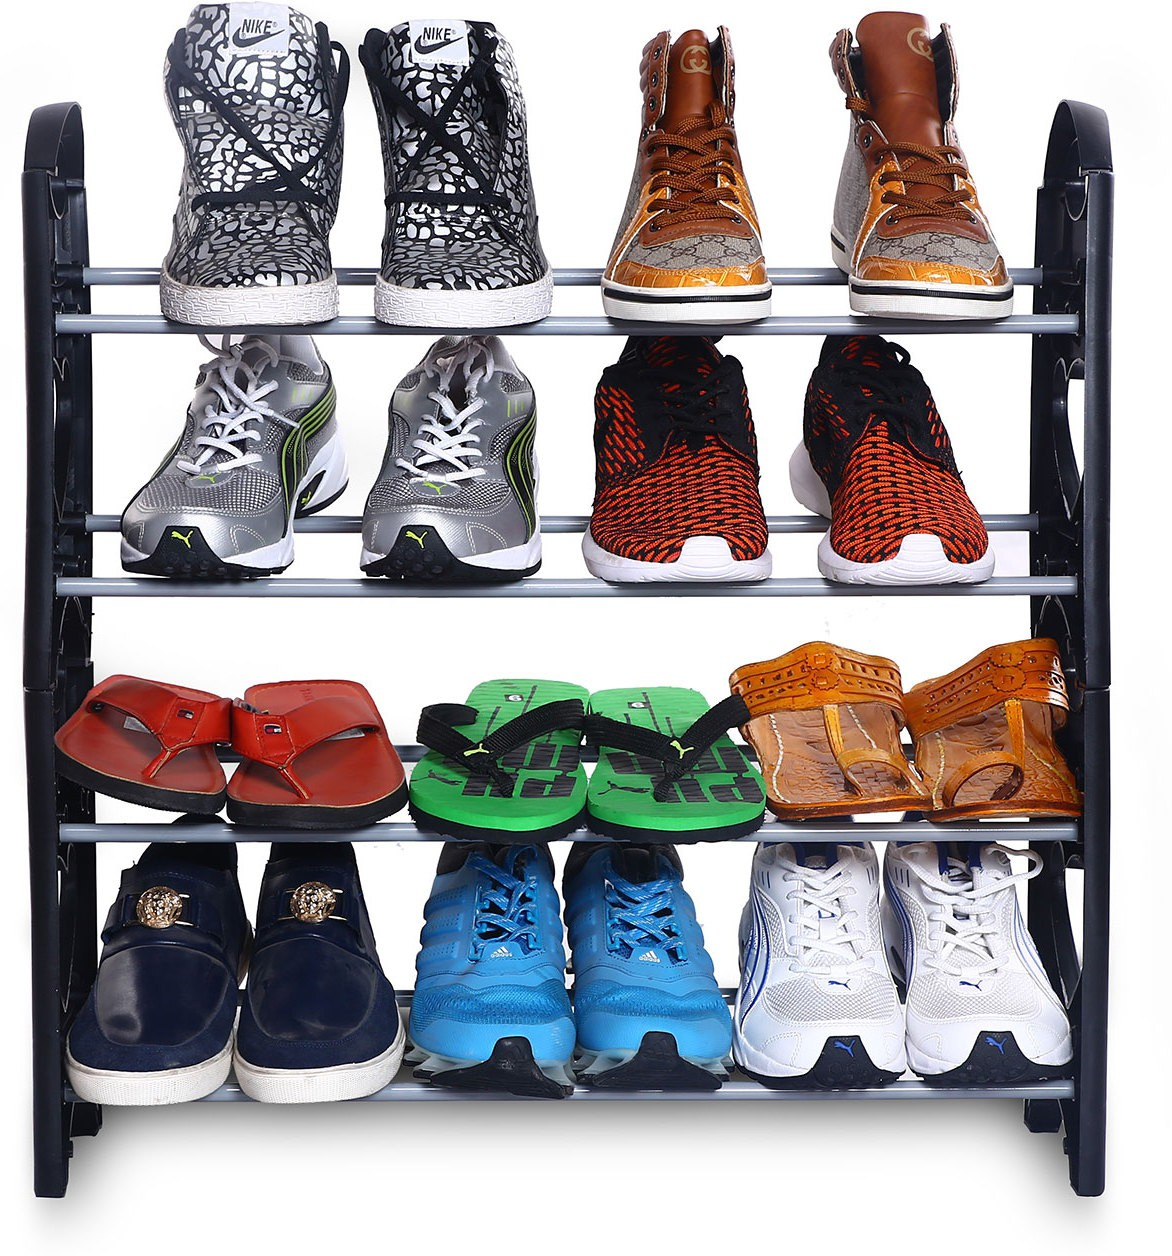

Furniture Birdy Stainless Steel Collapsible 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/2bc197275f1ed7210224d81887ba872c_sk-007-birdy-original-imaegnpyrgf6cz2e.jpeg


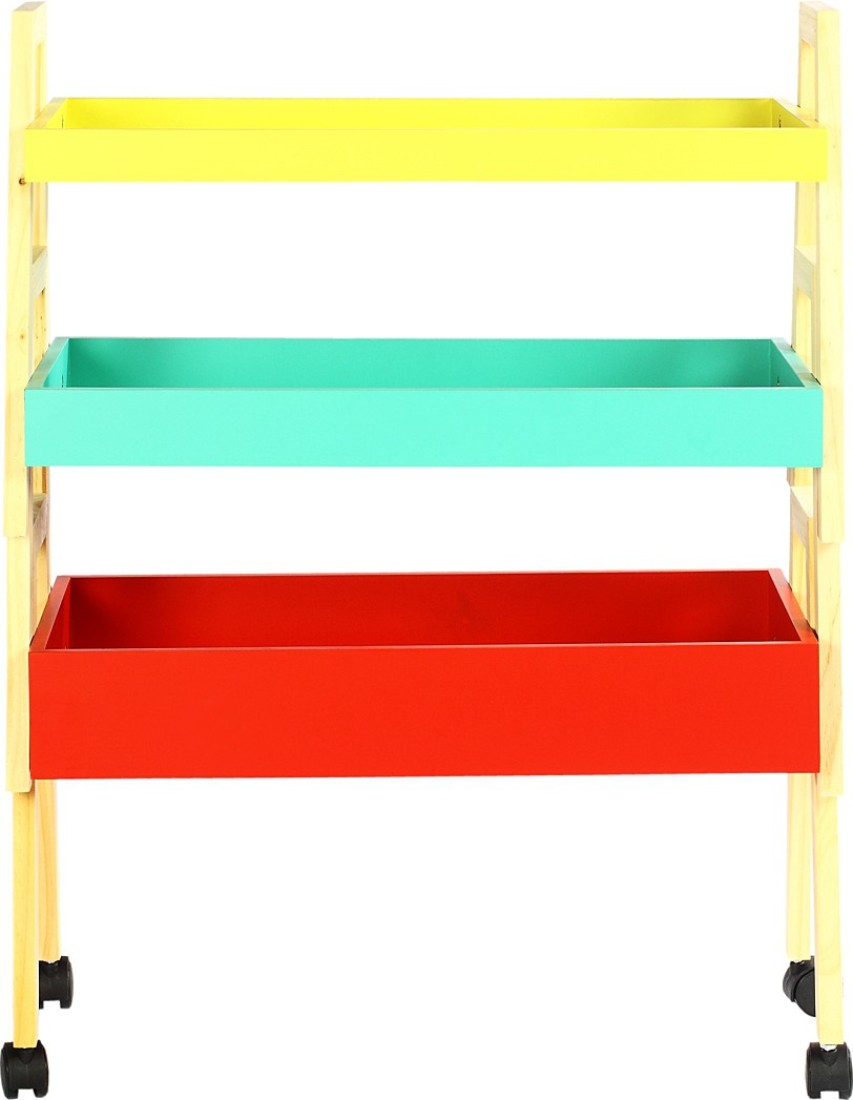

Furniture Living World by Home Stop Solid Wood Display Unit 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/eae96eb20ef0f1cb1c6897a01906c54c_fs584614s-005sg-oak-birch-batula-living-world-multicolor-1100x1100-imaeac33ypcqwerr.jpeg


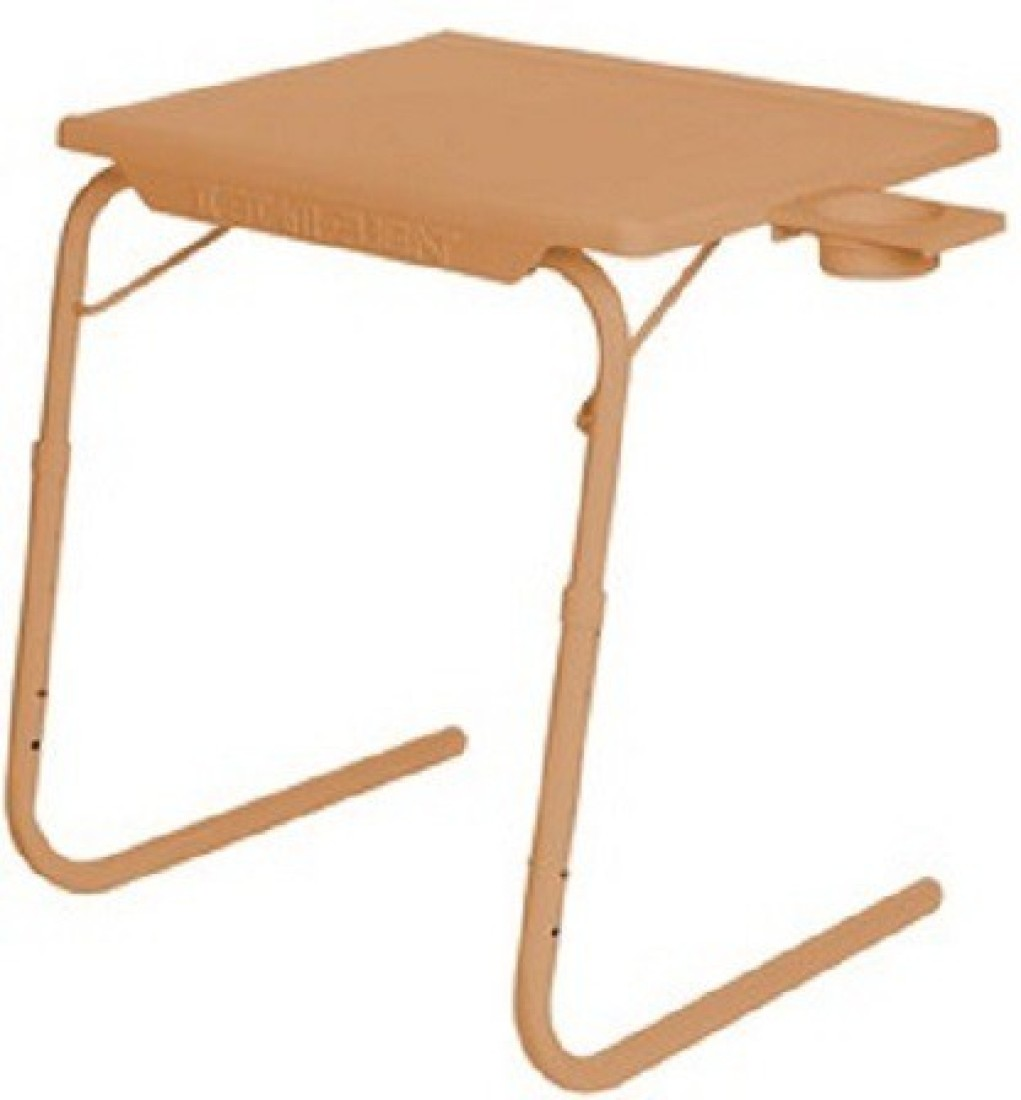

Furniture IBS Plastic Portable Laptop Table 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/a4e77c9989e9db8a1f952d611edda8c3_avar256-pp-ibs-beige-1100x1100-imae9etevhfmvbjr.jpeg


In [16]:
query = "kids furniture"
results = v_store.ann_search(n=6, vector=embed_query(query))

print("="*40)
print(f"Search: {query}")
print("="*40)
print("Results:")
print("-"*40)
for r in results:
    display(ShowImage(filename=r['metadata']['image_url'], width=200) )
    print(r['body_blob'])
    print(r['metadata']['image_url'])


Search:


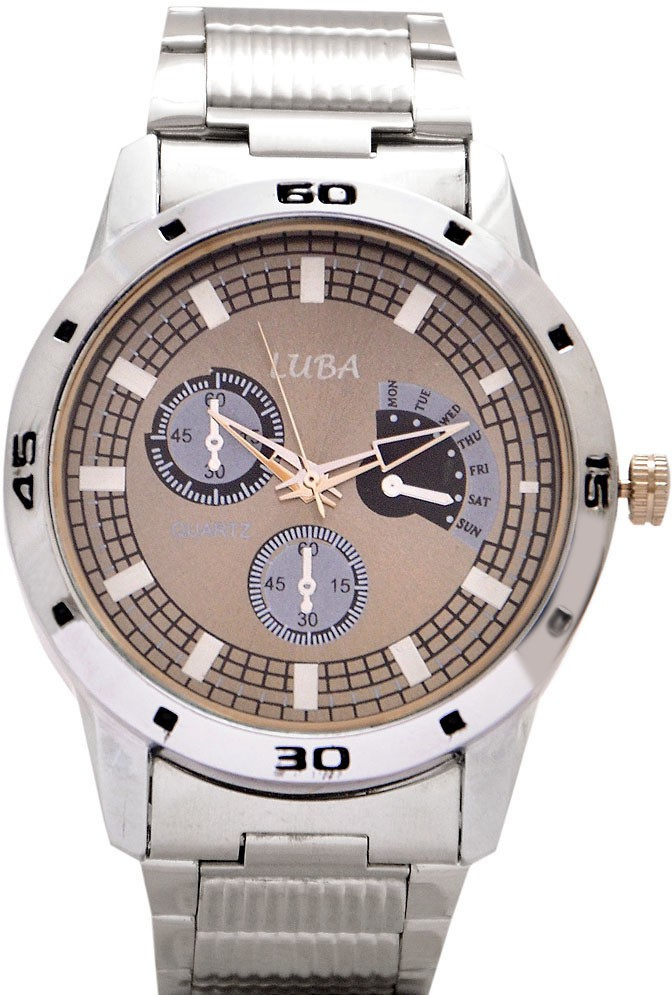

Results
----------------------------------------


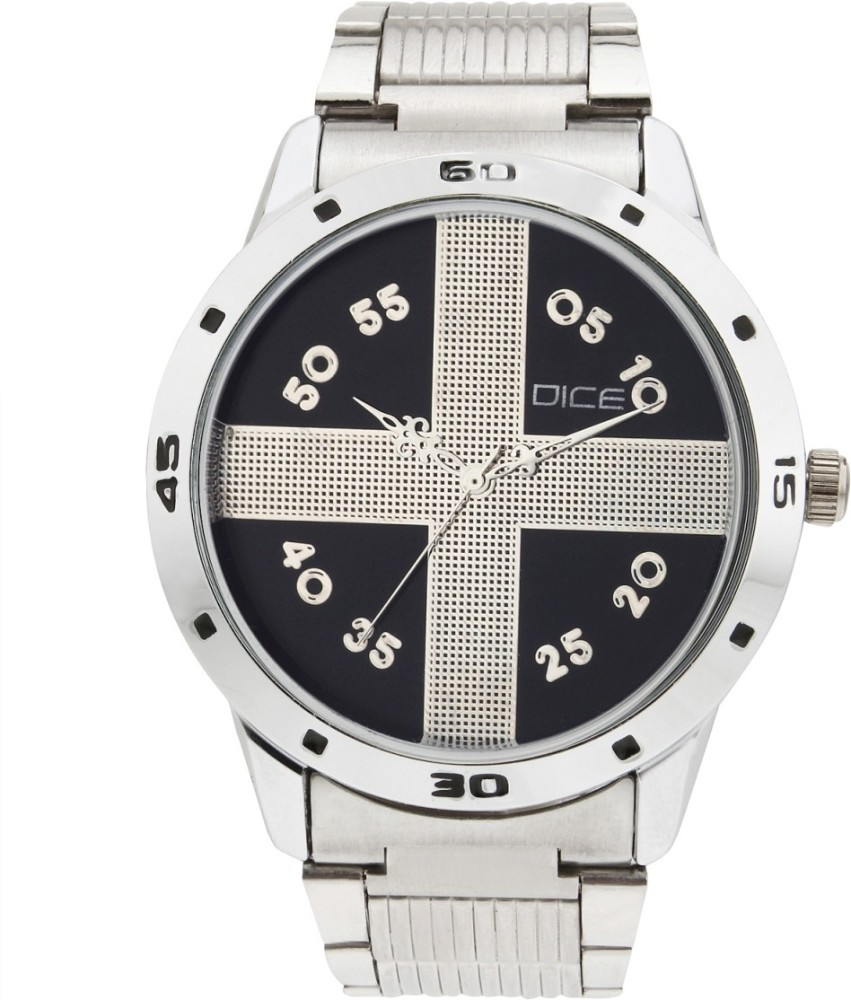

Watches DICE NMB-B148-4293 Numbers Analog Watch  - For Men, Boys 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/a86cbe126adde0673f59f70a64151989_nmb-b148-4293-dice-1000x1000-imaehxdqyurgugkn.jpeg


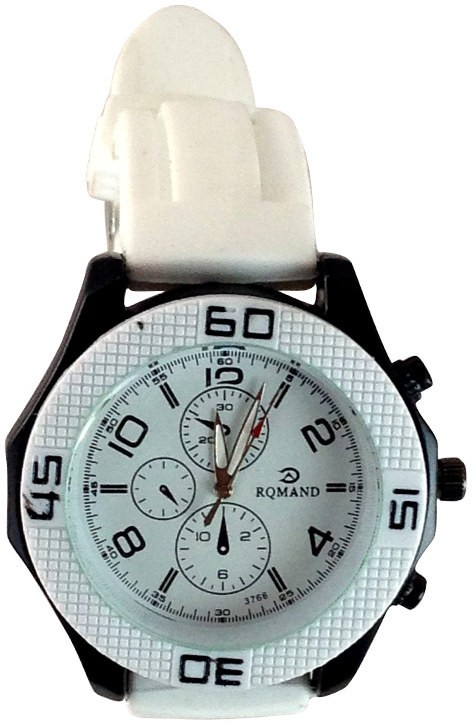

Watches Gift Island SW13389E Fashionin Digital Watch  - For Men 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/91a3651d11d2fee8abfb763429c93050_sw13389e-gift-island-original-imae37cbzdg7zgfg.jpeg


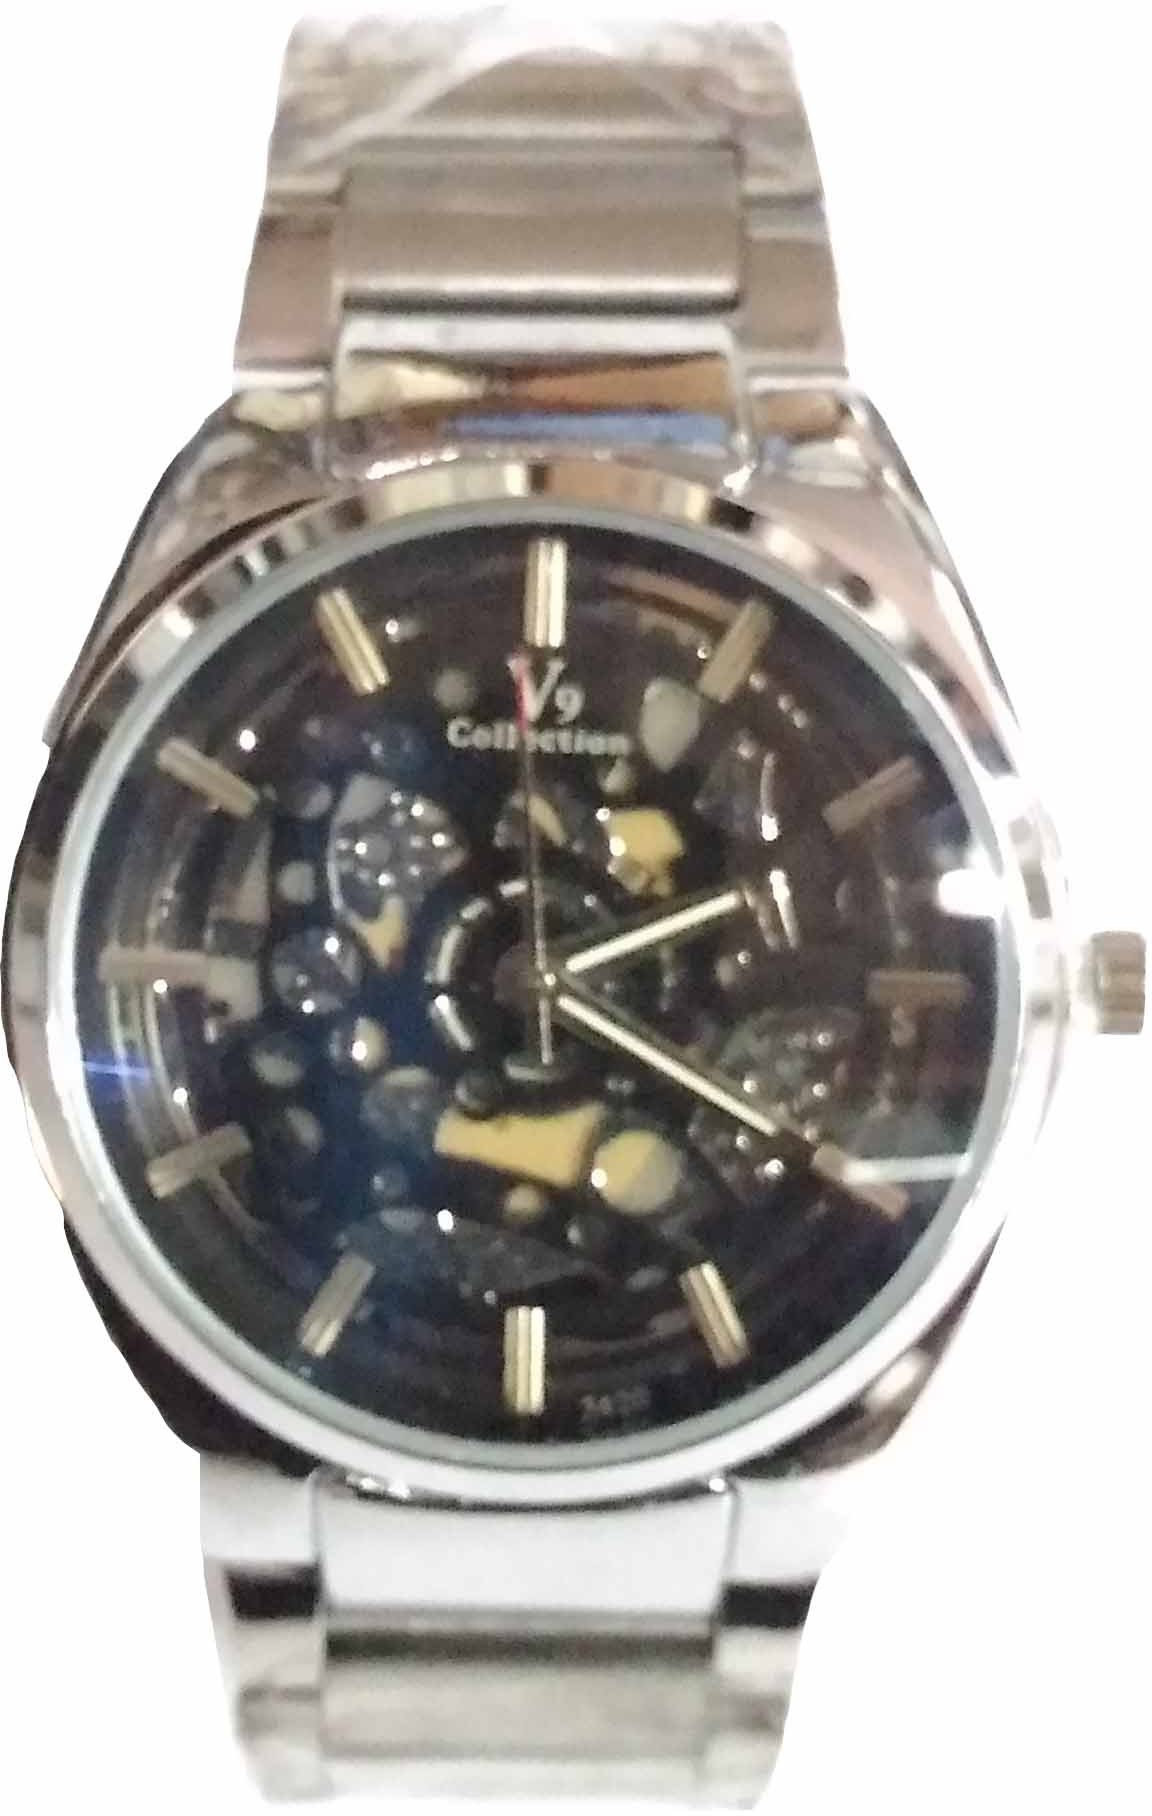

Watches V9 METAL STRAP Analog Watch  - For Men 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/08613e8b27838b997069b1fedb6e88d2_metal-strap-v9-original-imaehxhv9vzxyyb2.jpeg


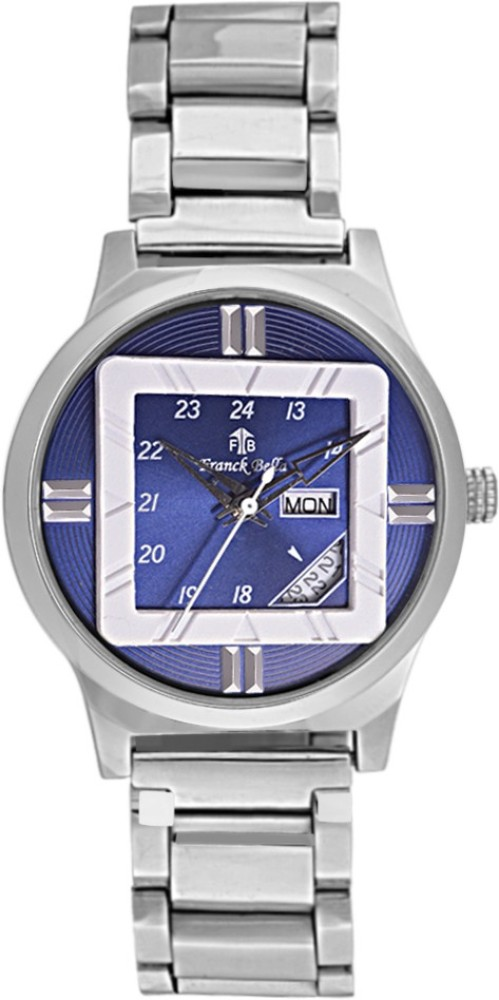

Watches Franck Bella FB0122DD Analog Watch  - For Men, Boys 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/22f01c289c956a7d29b15ea99d199963_fb0122dd-franck-bella-1000x1000-imaebr9qcqgma4vm.jpeg


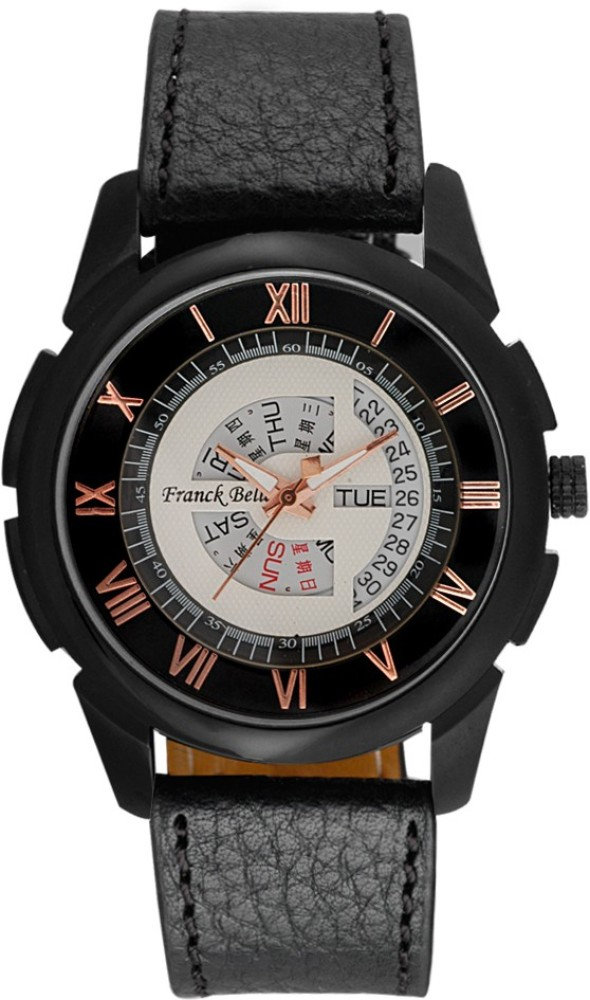

Watches Franck Bella FB123D Analog Watch  - For Men, Boys 
/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/e8194d7d46690b12ac80bb75ecca3b05_fb123d-franck-bella-1000x1000-imaeathtyywc6fgz.jpeg


In [17]:
file_to_search = '998276640805c5268d5b5f7534ef05e2_bh23-luba-original-imae9mn7hpk7hwrt.jpeg'
image_search = f"/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/{file_to_search}"
results = v_store.ann_search(n=5, vector=embed_image(image_search))

print("="*40)
print("Search:")
display(ShowImage(filename=image_search, width=200) )
print("="*40)
print("Results")
print("-"*40)

for r in results:
    display(ShowImage(filename=r['metadata']['image_url'], width=200) )
    print(r['body_blob'])
    print(r['metadata']['image_url'])

## Zero-Shot Classification

Reference: https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-use-openai-clip-classification.ipynb

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [28]:
categories = df['category'].unique()
classification_tokens = clip.tokenize(categories)

with torch.no_grad():
    text_features = model.encode_text(classification_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [29]:
#file_to_search = '946ec2dfec8ae7834e113c131c598d36_pbtmint4-mark-home-pbtmint4-original-imaefcqanczgzmmz.jpeg'
file_to_search = '998276640805c5268d5b5f7534ef05e2_bh23-luba-original-imae9mn7hpk7hwrt.jpeg'
image_path = f"/Users/samuel.matioli/work/gen-ai/multimodal/flipkart/images/{file_to_search}"
image_features = model.encode_image(image = transform(Image.open(image_path)).unsqueeze(0).to(device) )

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Classification


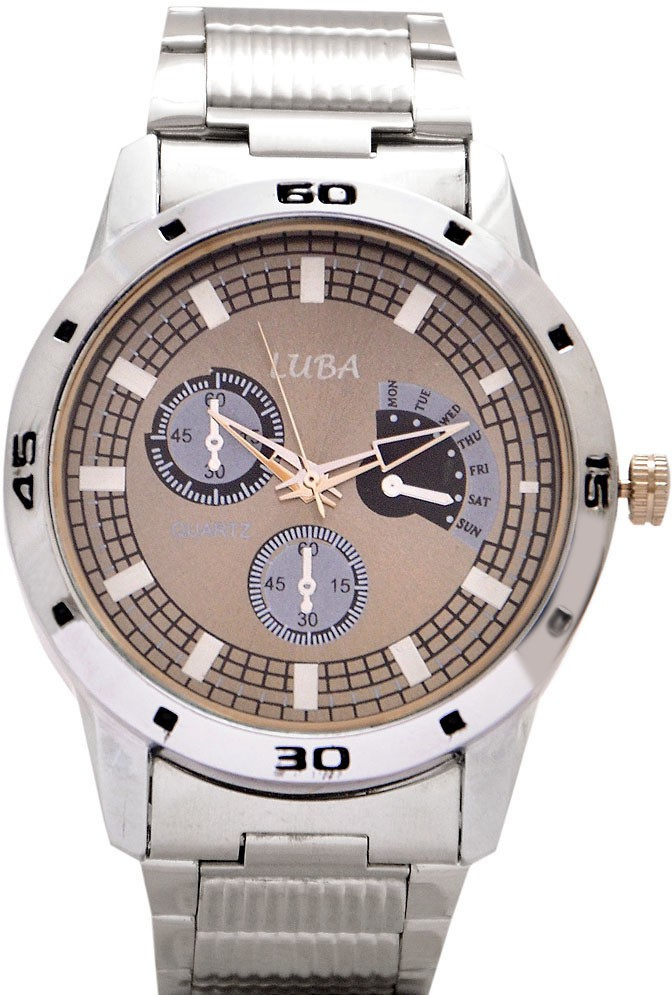

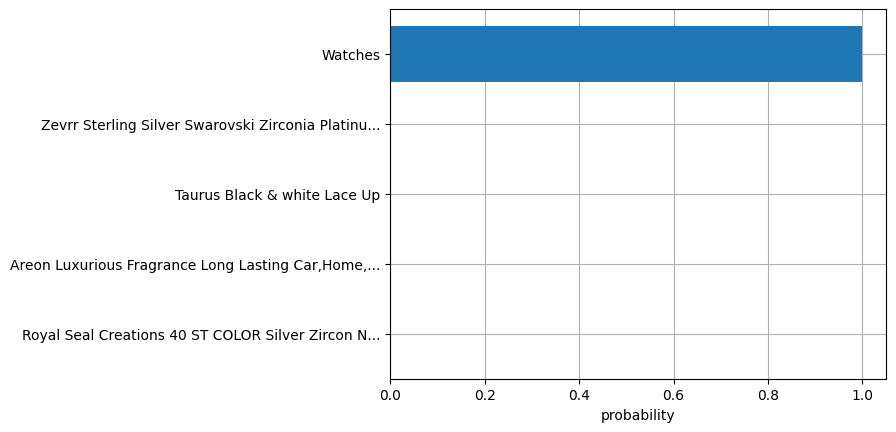

In [31]:
print("Classification")
print("="*40)
display(ShowImage(filename=image_path, width=200) )
print("="*40)

plt.grid()
y = np.arange(top_probs.shape[-1])
plt.barh(y, top_probs.detach().numpy()[0])
plt.gca().invert_yaxis()
plt.gca().set_axisbelow(True)
plt.yticks(y, [categories[index] for index in top_labels[0].numpy()])
plt.xlabel("probability")
plt.show()
